<a href="https://colab.research.google.com/github/oleksandragolub/Calcolatrice-Scientifica-in-java/blob/main/assignment3_aml_oleksandra_golub_856706.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Advanced Machine Learning (Assignment 3)**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

#### **Componenti del gruppo:**
— Oleksandra Golub (856706)

---
---

Link al dataset che ho utilizzato: [Bank Marketing Dataset](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset?select=bank.csv)

---
---



### **Librerie**
---
---


In [9]:
!pip install kagglehub

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import scipy.stats as st
import joblib
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report

# Set seed per riproducibilità, rende deterministica la casualità di NumPy e di TensorFlow
np.random.seed(42)
tf.random.set_seed(42)

print("Librerie importate con successo!")

Librerie importate con successo!



### **Caricamento dati**
---
---


In [10]:
# Per Google Colab
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cpu


In [11]:
# STEP 2: Definizione della CNN compatta
class CompactCNN(nn.Module):
    def __init__(self):
        super(CompactCNN, self).__init__()

        # Primo blocco convoluzionale
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)  # 1*8*3*3 + 8 = 80 params
        self.bn1 = nn.BatchNorm2d(8)  # 16 params (8*2)

        # Secondo blocco convoluzionale con stride per ridurre dimensioni
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)  # 8*16*3*3 + 16 = 1168 params
        self.bn2 = nn.BatchNorm2d(16)  # 32 params

        # Terzo blocco convoluzionale
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3, stride=2, padding=1)  # 16*24*3*3 + 24 = 3480 params
        self.bn3 = nn.BatchNorm2d(24)  # 48 params

        # Global Average Pooling invece di Flatten per ridurre parametri
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(24, 32)  # 24*32 + 32 = 800 params
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 10)  # 32*10 + 10 = 330 params

        # Totale: 80 + 16 + 1168 + 32 + 3480 + 48 + 800 + 330 = 5954 parametri

    def forward(self, x):
        # Primo blocco
        x = F.relu(self.bn1(self.conv1(x)))

        # Secondo blocco
        x = F.relu(self.bn2(self.conv2(x)))

        # Terzo blocco
        x = F.relu(self.bn3(self.conv3(x)))

        # Global Average Pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [12]:
# STEP 3: Funzione per contare e visualizzare i parametri
def analyze_model(model):
    print("Analisi del modello:")
    print("-" * 50)
    total_params = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"{name:30} | Shape: {str(param.shape):20} | Params: {num_params:,}")

    print("-" * 50)
    print(f"TOTALE PARAMETRI ADDESTRABILI: {total_params:,}")

    if total_params > 7000:
        print(f" ATTENZIONE: Il modello supera il limite di 7000 parametri!")
    else:
        print(f" OK: Il modello rispetta il limite ({7000 - total_params:,} parametri rimanenti)")

    return total_params

# Creiamo e analizziamo il modello
model = CompactCNN().to(device)
total_params = analyze_model(model)

Analisi del modello:
--------------------------------------------------
conv1.weight                   | Shape: torch.Size([8, 1, 3, 3]) | Params: 72
conv1.bias                     | Shape: torch.Size([8])      | Params: 8
bn1.weight                     | Shape: torch.Size([8])      | Params: 8
bn1.bias                       | Shape: torch.Size([8])      | Params: 8
conv2.weight                   | Shape: torch.Size([16, 8, 3, 3]) | Params: 1,152
conv2.bias                     | Shape: torch.Size([16])     | Params: 16
bn2.weight                     | Shape: torch.Size([16])     | Params: 16
bn2.bias                       | Shape: torch.Size([16])     | Params: 16
conv3.weight                   | Shape: torch.Size([24, 16, 3, 3]) | Params: 3,456
conv3.bias                     | Shape: torch.Size([24])     | Params: 24
bn3.weight                     | Shape: torch.Size([24])     | Params: 24
bn3.bias                       | Shape: torch.Size([24])     | Params: 24
fc1.weight            

In [13]:
# STEP 4: Preparazione del dataset MNIST
def prepare_data(batch_size=64):
    # Trasformazioni con data augmentation leggera
    transform_train = transforms.Compose([
        transforms.RandomRotation(5),  # Rotazione leggera
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Media e std di MNIST
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Download e caricamento dataset
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform_test)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = prepare_data()
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 60000
Test samples: 10000


In [14]:
# STEP 5: Funzioni di training e valutazione
def train_epoch(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)

    return avg_loss, accuracy

def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return test_loss, accuracy

In [18]:
# STEP 6: Training completo con learning rate scheduling
def train_model(model, train_loader, test_loader, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                      factor=0.5, patience=3)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    best_acc = 0

    for epoch in range(1, epochs + 1):
        print(f"\n{'='*60}")
        print(f"EPOCH {epoch}/{epochs}")
        print(f"{'='*60}")

        # Training
        train_loss, train_acc = train_epoch(model, device, train_loader,
                                           optimizer, criterion, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluation
        test_loss, test_acc = evaluate(model, device, test_loader, criterion)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # Learning rate scheduling
        scheduler.step(test_loss)

        # Mostra il learning rate corrente
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current Learning Rate: {current_lr:.6f}")

        # Salva il miglior modello
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f" Nuovo miglior modello salvato! Accuracy: {test_acc:.2f}%")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    return train_losses, train_accs, test_losses, test_accs, best_acc

In [19]:
# STEP 7: Avviamo il training
print("Iniziando il training...")
train_losses, train_accs, test_losses, test_accs, best_acc = train_model(
    model, train_loader, test_loader, epochs=20
)

Iniziando il training...

EPOCH 1/20
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308040
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.003542
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.679165
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.465292
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.341060
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.851835
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.885572
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.818351
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.011886
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.714767

Test set: Average loss: 0.5662, Accuracy: 8314/10000 (83.14%)

Current Learning Rate: 0.001000
 Nuovo miglior modello salvato! Accuracy: 83.14%
Train Loss: 1.2663, Train Acc: 56.30%
Test Loss: 0.5662, Test Acc: 83.14%

EPOCH 2/20
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.797513
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.793592
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.788315
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.609363
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.6

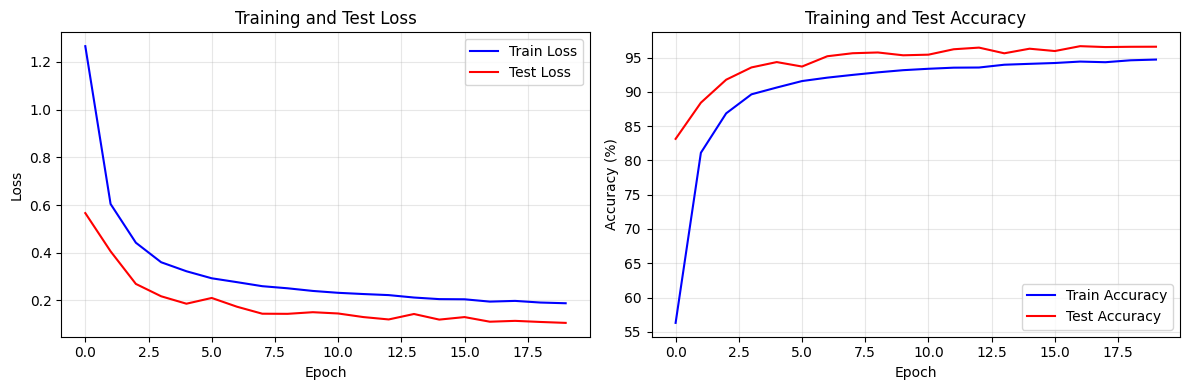


 Miglior accuracy sul test set: 96.66%


In [20]:
# STEP 8: Visualizzazione dei risultati
def plot_training_history(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(test_losses, label='Test Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Accuracy', color='blue')
    ax2.plot(test_accs, label='Test Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Test Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=100)
    plt.show()

plot_training_history(train_losses, train_accs, test_losses, test_accs)
print(f"\n Miglior accuracy sul test set: {best_acc:.2f}%")

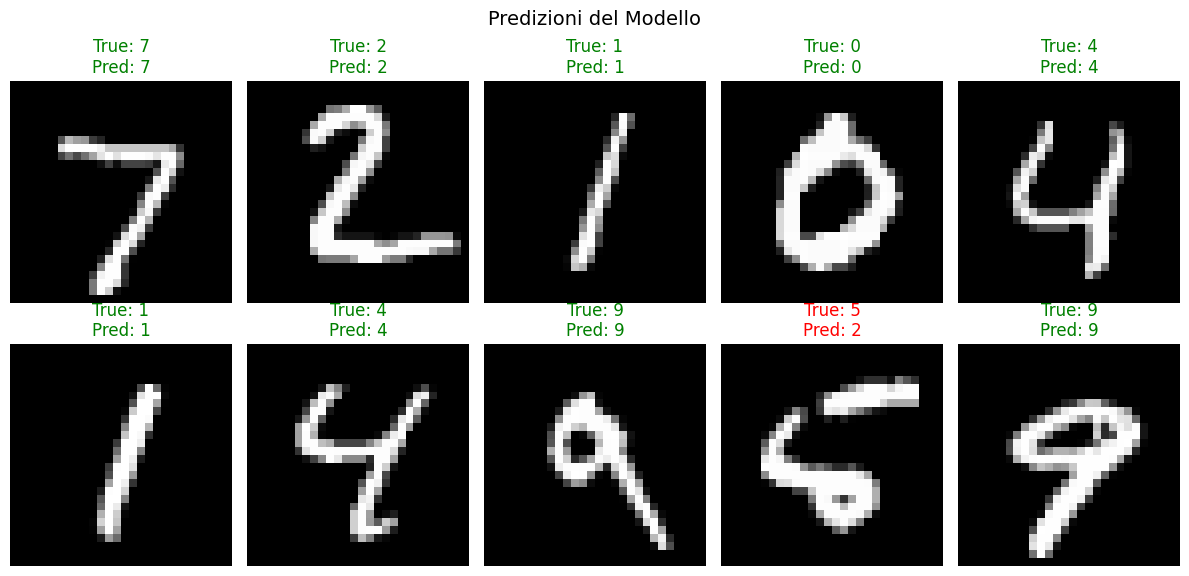

In [21]:
# STEP 9: Visualizzazione di alcune predizioni
def visualize_predictions(model, test_loader, num_images=10):
    model.eval()

    # Prendi un batch dal test loader
    data, target = next(iter(test_loader))
    data, target = data[:num_images].to(device), target[:num_images].to(device)

    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1)

    # Visualizza
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_images):
        img = data[i].cpu().numpy().squeeze()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {target[i].item()}\nPred: {pred[i].item()}',
                         color='green' if target[i] == pred[i] else 'red')
        axes[i].axis('off')

    plt.suptitle('Predizioni del Modello', fontsize=14)
    plt.tight_layout()
    plt.savefig('predictions.png', dpi=100)
    plt.show()

visualize_predictions(model, test_loader)

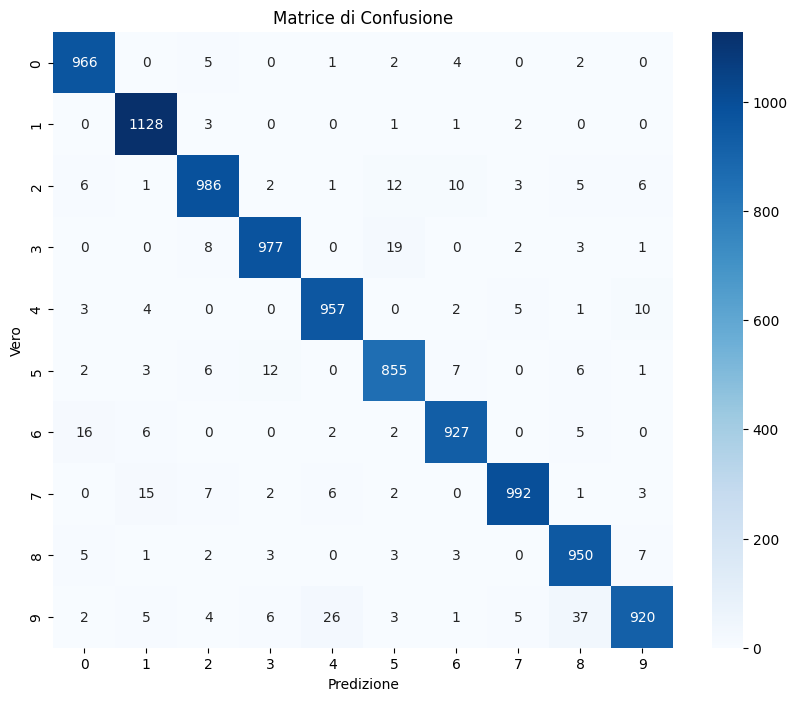

Classe 0: 98.57% accuracy
Classe 1: 99.38% accuracy
Classe 2: 95.54% accuracy
Classe 3: 96.73% accuracy
Classe 4: 97.45% accuracy
Classe 5: 95.85% accuracy
Classe 6: 96.76% accuracy
Classe 7: 96.50% accuracy
Classe 8: 97.54% accuracy
Classe 9: 91.18% accuracy


In [22]:
# STEP 10: Analisi degli errori e matrice di confusione
from sklearn.metrics import confusion_matrix
import seaborn as sns

def analyze_errors(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Matrice di confusione
    cm = confusion_matrix(all_targets, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title('Matrice di Confusione')
    plt.xlabel('Predizione')
    plt.ylabel('Vero')
    plt.savefig('confusion_matrix.png', dpi=100)
    plt.show()

    # Calcola accuracy per classe
    class_acc = cm.diagonal() / cm.sum(axis=1)
    for i in range(10):
        print(f"Classe {i}: {class_acc[i]*100:.2f}% accuracy")

    return cm

cm = analyze_errors(model, test_loader)